# Homework 2 - Generalized Hough Transform

## Theory

Task 1: The ii) Table
Task 2: A Triangle

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window  

    Returns
    -------
    result : ndarray

    """
    rows,cols = img.shape
    result = np.zeros_like(img)
    for i in range(2*d,rows-2*d):
        for j in range(2*d,cols-2*d):
            low_y = max(0, i-d)
            low_x = max(0, j-d)
            high_y = min(rows, i+d)
            high_x = min(cols, j+d)
            max_val = img[low_y:high_y,low_x:high_x].max()
            is_max = np.abs(img[i,j] - max_val) < 0.0000001
            result[i,j] = max_val*is_max

    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    gradients = cv2.Laplacian(img,cv2.CV_8U)
    binarized = (gradients > (thresh * 255))

    return binarized


def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """

    image_gradient = compute_gradients(img)
    template_gradient = compute_gradients(template)
    template_gradient = crop_template(template_gradient)

    template_height, template_width = template_gradient.shape
    image_height, image_width = image_gradient.shape

    tg_normalized = (template_gradient - np.mean(template_gradient)) / np.std(template_gradient)

    # -compute correlation
    corr_image = np.zeros((
        image_height + template_height - 1,
        image_width + template_width - 1)
    )

    for y in range(-template_height + 1, image_height):
        for x in range(-template_width + 1, image_width):
            # Get the image region to analyse
            region = get_padded_region(image_gradient, (x, y), tg_normalized.shape)
            # Normalize the region
            region_mean = np.mean(region)
            region_std = np.std(region)
            if region_std == 0:
                region_normalized = (region - region_mean)
            else:
                region_normalized = (region - region_mean) / region_std
            corr = np.sum(region_normalized * tg_normalized)

            # Save the correlation
            corr_image[template_height + y - 1, template_width + x - 1] = corr

    corr_image = crop_center(corr_image, img.shape)
    return corr_image

# Returns a requested image region
# If the template overlaps the actual image, the border will be "blacked out"
def get_padded_region(image, top_left, template_shape):
    h, w = template_shape
    region = np.zeros((h, w), dtype=image.dtype)

    y1 = max(0, top_left[1])
    y2 = min(image.shape[0], top_left[1] + h)
    x1 = max(0, top_left[0])
    x2 = min(image.shape[1], top_left[0] + w)

    region_y1 = max(0, -top_left[1])
    region_y2 = region_y1 + (y2 - y1)
    region_x1 = max(0, -top_left[0])
    region_x2 = region_x1 + (x2 - x1)

    region[region_y1:region_y2, region_x1:region_x2] = image[y1:y2, x1:x2]

    return region

def compute_gradients(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(grad_x, grad_y)
    return magnitude

def crop_template(template):
    # Find the bounding box of the non-black pixels in the template
    coords = cv2.findNonZero(template)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_template = template[y:y+h, x:x+w]
    return cropped_template

def crop_center(image, target_shape):
    center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    target_h, target_w = target_shape
    start_y = center_y - target_h // 2
    start_x = center_x - target_w // 2
    return image[start_y:start_y + target_h, start_x:start_x + target_w]


def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        Note the order of these values.
    """
    hough_table = []
    total_images = len(scales) * len(angles)
    i = 0
    for scale in scales:
        for angle in angles:
            #h, w = template.shape
            #template = utils.circularShift(template, int(w/2) , int(h/2))
            template_resized = utils.rotateAndScale(template, angle, scale)
            #utils.show(template_resized)
            corr = correlation(img, template_resized)
            hough_table.append([corr, angle, scale])
            i += 1
            print("ght progress: (" + str(i) + "/" + str(total_images) + ")")

    print("HOUGH ANALYSIS DONE")
    return hough_table

# Main Program

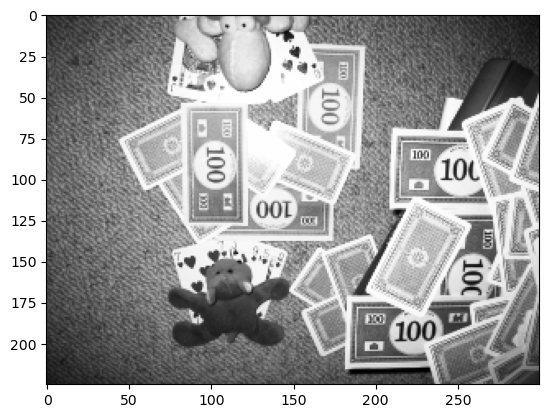

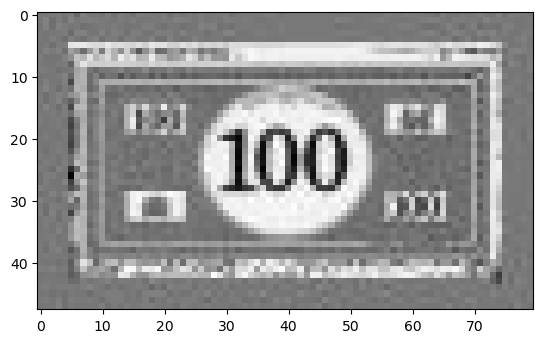

[  0.  90. 180.]
[0.9  0.98 1.06 1.14 1.22 1.3 ]
ght progress: (1/18)
ght progress: (2/18)
ght progress: (3/18)
ght progress: (4/18)
ght progress: (5/18)
ght progress: (6/18)
ght progress: (7/18)
ght progress: (8/18)
ght progress: (9/18)
ght progress: (10/18)
ght progress: (11/18)
ght progress: (12/18)
ght progress: (13/18)
ght progress: (14/18)
ght progress: (15/18)
ght progress: (16/18)
ght progress: (17/18)
ght progress: (18/18)
HOUGH ANALYSIS DONE


In [24]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
#angles = np.linspace(0, 180, 4)
angles = np.linspace(0, 180, 3)
print(angles)
#scales = np.linspace(0.9, 1.3, 4)
scales = np.linspace(0.9, 1.3, 6)
print(scales)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)


Hough votes


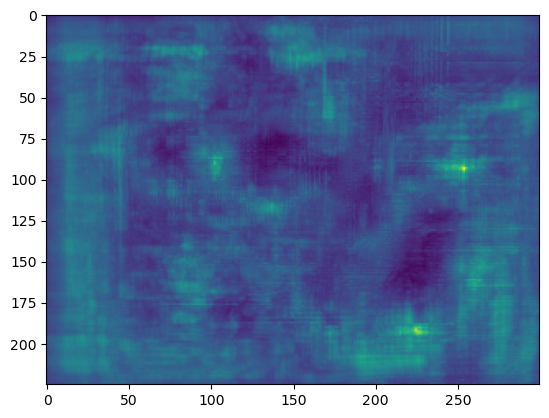

(225, 300)
Filtered Hough votes


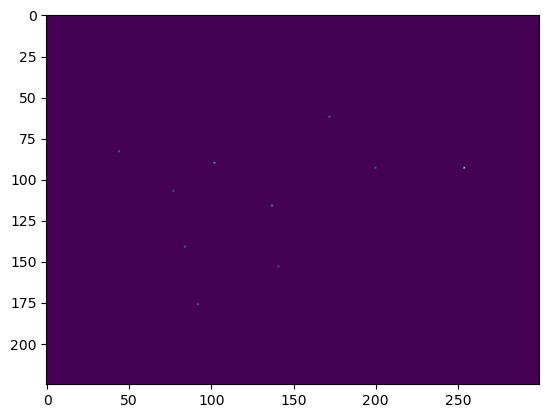

Detected Positions
141 153
77 107
254 93
102 90
172 62
137 116
84 141
92 176
200 93
44 83


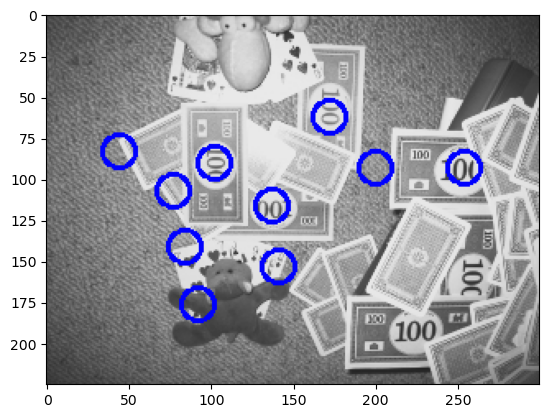

In [25]:
# Visualize votes
print("Hough votes")
votes_stacked = np.stack(votes).max(0)
plt.imshow(votes_stacked)
plt.show()

print(votes_stacked.shape)

# nonMaxSuprression
print("Filtered Hough votes")
votes_nms = nonMaxSuprression(votes_stacked, 20)
plt.imshow(votes_nms)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes_nms, -n, axis=None)[-n:], votes_nms.shape))
vis = np.stack(3*[query],2)
print("Detected Positions")
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)

In [ ]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


def testGHT():
    # Load Images
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    
    # GHT with search space
    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    # Visualize GHT votes
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    # Visualize filtered points
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    # Extract n points wiht highest voting score
    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))
    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    # Compare with ground-truth centroids
    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    # Visualize centroids
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    # Compute Distances and apply threshold
    coords = np.array(coords)[:,::-1]
    d = euclidean_distances(centroids, coords).min(1)
    correct_detections = np.count_nonzero((d<10))
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()